In [1]:
# 我會盡量幫大家做足註解
# 讓大家比較知道在做甚麼
# 基本上中文的註解應該是我註的
# 英文的就是原作者啦

In [2]:
# 目前已經測試過可以跑起來，再跑起來之前要請大家注意以下事項： 
#       p.s. 記得設定捷徑連到 data 和 model_final 資料夾
# 1. "model.compile()" 那裏的 epoch 數字請根據自己做實驗需求設定，原作者設定 150
# 2. "train_path", "test_path" 是需要大家根據自己的資料夾位置填寫的變數，train 大約 2 處、test 大約 1 處，有特別註解強調，請大家再注意
# 3. "save_model_path" 同上，大約有 2 處，也請大家填上自己的 model_final 資料夾路徑
# 4. 執行 test 後，結果會存在 "test_output.txt"，但請大家把這個檔名改掉（不要跟別人重複），不然會不小心覆寫別人的檔案
# 5.  "encoder_model.h5", "decoder_model_weights.h5", "tokenizer" 更重要，一定要改檔名，不然覆寫掉了別人的會很恐怖
#       也就是說，只要 "前綴有 model_final 資料夾的"，請務必取一個別的檔名！！
# 6. 我發現執行 1 個 epoch 需要 1hr.，所以要留給他多點時間

# 2022.5.5 更新 ##
# 1. batch_size 已經改成 256，有 1 處 model.fit 和 2 處 load_dataset 需要更改
# 2. 新增 2 個 block：安裝 SPICE 套件、執行 spice 計算 test 準確度（指定路徑和檔名也要改）
# 3. 補充：load_model 部分的 h5 檔案也需要更改

# 2022.5.12 更新 ##
# 1. 新增 predict_realtime（無法播放影片，只能產生字幕）
# 2. 待測影片請放置新增資料夾 data/demo_data/video
# 3. 下面 config 部分，"#######" 註解那裏請改成自己的路徑及參數

In [3]:
### 連結雲端 ###

# 可以在自己雲端建立資料集的捷徑就可以用了
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
### 程式開跑前先import ###
import datetime
import os, sys
import json
import random
import numpy as np
import joblib
import keras
import tensorflow as tf
import pickle, functools, operator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [5]:
### 把 training_data 全部 load 進來 ###

# 設定 training data label 的 json 檔路徑
train_path='/content/drive/MyDrive/特徵擷取區bykelly/data/training_data'   ####### 這裡要改成自己的 training_data 資料夾（/content 之後） ######
TRAIN_LABEL_PATH = os.path.join(train_path, 'training_label.json')

# 所有 training_data 還會再被分為 85% 的 training set & 15% 的 validation set
# mentioning the train test split
train_split = 0.85

# load training data label 的 json 檔
# loading the json file for training
with open(TRAIN_LABEL_PATH) as data_file:    
    y_data = json.load(data_file)

# train_list contains all the captions with their video ID
# vocab_list contains all the vocabulary from training data
train_list = []
vocab_list = []

# 遍歷 json 檔案，在各句子前後分別加上 <bos>, <eos>，然後淘汰長度小於 6 or 大於 10 的句子
for y in y_data:
  for caption in y['caption']:
    caption = "<bos> " + caption + " <eos>"
    # we are only using sentences whose length lie between 6 and 10
    if len(caption.split())>14 or len(caption.split())<6:
      continue
    else:
      train_list.append([caption, y['id']])
print(len(train_list))

# 把全部句子洗牌，然後分出 85% train 和 15% validation
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]

# 把每句 caption 加入 vocab_list，等下要用工具拆出單字
for train in training_list:
    vocab_list.append(train[0])

# 用 Tokenizer 拆解每句 caption 的單字，並且取其中頻率最高的 1500 個單字 (Tokenizer 詳細用法解說：https://www.twblogs.net/a/5c113708bd9eee5e4183a621)
# Tokenizing the words
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(vocab_list)
print(len(tokenizer.word_index))

# 設定存 feature 的路徑
TRAIN_FEATURE_DIR = os.path.join(train_path, 'feat')

# load 進來已經處理好的 training_data 的 feature
# Loading all the numpy arrays at once and saving them in a dictionary
x_data = {}
for filename in os.listdir(TRAIN_FEATURE_DIR):
    f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename))
    x_data[filename[:-4] + ".avi"] = f   # 把副檔名(.npy)去掉，只留 id
print(len(training_list))
print(len(validation_list))
len(x_data)

# 需要有 training_data 的資料夾
# training_data 資料夾裡面要有 training_label.json
# training_data 資料夾裡面要有 feat 資料夾
# 這裡的 os 要改成可以讀的路徑

70823
10301
60199
10624


1870

In [6]:
### Dataset 產生器 ###
# 分成 training set 和 validation set 讀進來，將同影片不同句子配對

# 設定 train_data 資料夾路徑
train_path='/content/drive/MyDrive/特徵擷取區bykelly/data/training_data'   ####### 這裡要改成自己的 training_data 資料夾（/content 之後） ######

# Creating a custom data generator because we cannot load so many files at once
def load_datatest(train_path, epochs=100, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=3000,training_list=train_list, batch_size=32, maxlen=14):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []

    # 拆成 ID, sequence 兩個 list，其中 training_list 的資料結構：(caption, video_id)
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
        
    # 把所有 caption 的單字全部轉成 np_array，長度不足 10 的補上 0
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)   # pad_sequences 的詳細用法解說：https://blog.csdn.net/wcy23580/article/details/84957471
    max_seq_length = train_sequences.shape[1]   # 都已經讓長度是 10 了所以這裡就是 10
    filesize = len(train_sequences)     # 總共有幾句 caption

    # 組織 encoder, decoder 需要的資料結構
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    for i in range(epochs):             # 要產生幾輪資料
      for idx in  range(0,filesize):    # 每句 caption
        n += 1
        encoder_input_data.append(x_data[videoId[idx]])                 # 存進 feature
        y = to_categorical(train_sequences[idx], num_decoder_tokens)    # 把每句 caption 的單字都照著 top 1500 單字下去編碼，沒在 top 1500 的字全會被分到同一類
        decoder_input_data.append(y[:-1])   # 去掉 <eos>
        decoder_target_data.append(y[1:])   # 去掉 <bos>
        if n == batch_size:     # 依照 batch_size 的大小分出資料
          encoder_input = np.array(encoder_input_data)
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0
          yield ([encoder_input, decoder_input], decoder_target)    # yield 會記住這次執行到哪裡，然後暫停住，把值 return 回去
                                                                    # yield 詳細用法解說：https://blog.csdn.net/mieleizhi0522/article/details/82142856

In [7]:
### 宣告 train set 以及 validation set 的生成器 ###
# 因為 load_data 用了 yield，已經不是一個函式了，可以當作一個生成器，這裡只是宣告生成器而已
# writing the train and validation generator
train = load_datatest(train_path=train_path,batch_size=256, training_list=training_list, x_data=x_data, epochs=150)
valid = load_datatest(train_path=train_path,batch_size=256, training_list=validation_list, x_data=x_data, epochs=150)

In [8]:
### 宣告會用到的常數 ###
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=80       # frame 數量
num_encoder_tokens=4096     # 每個 frame 的特徵數量
latent_dim=512              # LSTM 的 hidden features
time_steps_decoder=8       # 每個產生的句子的最大長度
num_decoder_tokens=3000     # 產生的單字選擇數
batch_size=256              # batch size

In [9]:
### 宣告 Encoder 和 Decoder ###

# 他的 encoder, decoder 設計方式和官網範例一樣：https://keras.io/zh/examples/lstm_seq2seq/
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")   # Input 層，(80, 4096)
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')       # LSTM
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")  # Input 層，(80, 10)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')  # LSTM
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
# plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 80, 4096)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 8, 3000)]    0           []                               
                                                                                                  
 endcoder_lstm (LSTM)           [(None, 80, 512),    9439232     ['encoder_inputs[0][0]']         
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

In [10]:
### 不一定要執行，看訓練過程的 ###
# Loading the tensorboard to visualise results
#%load_ext tensorboard
#import datetime
#%tensorboard --logdir logs

In [11]:
### 設定一些停止條件以後就可以讓 model 跑起來了 ###

# 一旦 validation set 連續 5 個 epoch 都沒有再提升，就停止訓練（詳細用法解說：https://cynthiachuang.github.io/EarlyStopping-Callback/）
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 設定優化方式，開跑！
# Run training
opt = tf.keras.optimizers.Adam(lr = 0.00035)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')


try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=28, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/28
235/235 [==============================] - 143s 578ms/step - loss: 2.9297 - accuracy: 0.5269 - val_loss: 2.4886 - val_accuracy: 0.5599 - lr: 3.5000e-04
Epoch 2/28
235/235 [==============================] - 143s 610ms/step - loss: 2.3292 - accuracy: 0.5955 - val_loss: 2.1588 - val_accuracy: 0.6279 - lr: 3.5000e-04
Epoch 3/28
235/235 [==============================] - 143s 609ms/step - loss: 2.0399 - accuracy: 0.6422 - val_loss: 1.9144 - val_accuracy: 0.6584 - lr: 3.5000e-04
Epoch 4/28
235/235 [==============================] - 143s 608ms/step - loss: 1.8171 - accuracy: 0.6709 - val_loss: 1.7295 - val_accuracy: 0.6815 - lr: 3.5000e-04
Epoch 5/28
235/235 [==============================] - 135s 575ms/step - loss: 1.6507 - accuracy: 0.6929 - val_loss: 1.5979 - val_accuracy: 0.6987 - lr: 3.5000e-04
Epoch 6/28
235/235 [==============================] - 135s 575ms/step - loss: 1.5237 - accuracy: 0.7092 - val_loss: 1.4909 - val_accuracy: 0.7139 - lr: 3.5000e-04
Epoch 7/28
235/235 [==

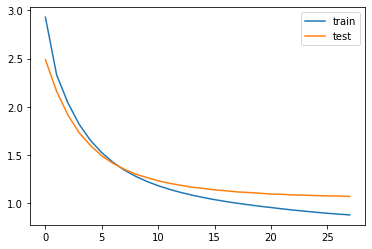

In [12]:
### 不一定要執行，看訓練結果的 ###
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss.png')
plt.show()

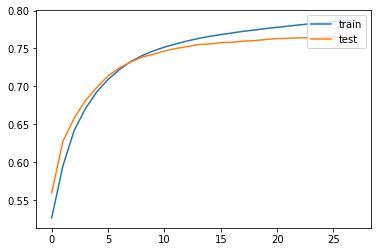

In [13]:
### 不一定要執行，看訓練結果的 ###
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy.png')
plt.show()

In [14]:
### 把 train 好的 model 存起來 ###

# 建立 model_final 資料夾       ####### 記得改成自己的 "model_final" 路徑 #######
save_model_path = '/content/drive/MyDrive/ColabNotebooks/model_final'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# 印出 model 總結的，不用太在意
encoder_model.summary()
decoder_model.summary()

# 把 Encoder 和 Decoder 各存成 h5 檔，也寫入 tokenizer1500 單字檔
####### "encoder_model.h5", "decoder_model_weights.h5", "tokenizer" 3 個檔案也要改檔名！！ #######
encoder_model.save(os.path.join(save_model_path, 'jennifer_1_encoder_model.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'jennifer_1_decoder_model_weights.h5'))
with open(os.path.join(save_model_path,'jennifer_1_tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)

# plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)
# plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 80, 4096)]       0         
                                                                 
 endcoder_lstm (LSTM)        [(None, 80, 512),         9439232   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 9,439,232
Trainable params: 9,439,232
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 8, 3000)]    0           []                               

In [15]:
### 這裡是定義 test 的部分 ###
# test 執行後會存成一個 txt 檔案再 model_final 資料夾，可以再去那邊確認
# class to perform inference on all test files and save as test_output.txt
class Video2Text(object):
    ''' Initialize the parameters for the model '''
    def __init__(self):
        self.latent_dim = 512
        self.num_encoder_tokens = 4096
        self.num_decoder_tokens = 3000
        self.time_steps_encoder = 80
        self.time_steps_decoder = None
        self.preload = True
        self.preload_data_path = 'preload_data'
        self.max_probability = -1

        # processed data
        self.encoder_input_data = []
        self.decoder_input_data = []
        self.decoder_target_data = []
        self.tokenizer = None

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None       ####### 下面 2 行要記得改成自己的 "model_final" 和 "testing_data" 路徑 #######
        self.save_model_path = '/content/drive/MyDrive/ColabNotebooks/model_final'
        self.test_path = '/content/drive/MyDrive/特徵擷取區bykelly/data/testing_data'
        
    def load_inference_models(self):
        # load tokenizer
        
        with open(os.path.join(self.save_model_path, 'jennifer_1_tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)

        # inference encoder model
        self.inf_encoder_model = load_model(os.path.join(self.save_model_path, 'jennifer_1_encoder_model.h5'))

        # inference decoder model
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens))
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax')
        decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True)
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.inf_decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        self.inf_decoder_model.load_weights(os.path.join(self.save_model_path, 'jennifer_1_decoder_model_weights.h5'))
    
    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value,[],[],0)
        return decode_seq

    def beam_search(self, target_seq, states_value, prob,  path, lens):
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape((self.num_decoder_tokens))
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 14
            if(sampled_char != 'eos' and lens <= MAX_LEN):
                p = output_tokens[sampled_token_index[i]]
                if(sampled_char == ''):
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens+1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if(p > self.max_probability):
                    decode_seq = path
                    self.max_probability = p

    def decoded_sentence_tuning(self, decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        unigram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in unigram:
                unigram[c] += 1
            else:
                unigram[c] = 1
            if(last_string == c and idx2 > 0):
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def get_test_data(self, path):
        X_test = []
        X_test_filename = []
        with open (os.path.join(path, 'testing_id.txt')) as testing_file:
            lines = testing_file.readlines()
            for filename in lines:
                filename = filename.strip()
                f = np.load(os.path.join(path , 'feat', filename[:-4] + '.npy'))
                X_test.append(f)
                X_test_filename.append(filename[:-4])
            X_test = np.array(X_test)
        return X_test, X_test_filename

    def test(self):
        X_test, X_test_filename = self.get_test_data(os.path.join(self.test_path))
        print(len(X_test), len(X_test_filename))
        # generate inference test outputs     ####### test_output.txt 請改成自己取的檔名，才不會把別人的覆寫掉 #######
        with open(os.path.join(self.save_model_path, 'jennifer_1_test_output.txt'), 'w') as file:
            for idx, x in enumerate(X_test): 
                file.write(X_test_filename[idx]+',')
                decoded_sentence = self.decode_sequence2bs(x.reshape(-1, 80, 4096))
                decode_str = self.decoded_sentence_tuning(decoded_sentence)
                for d in decode_str:
                    file.write(d + ' ')
                file.write('\n')
                # re-init max prob
                self.max_probability = -1

In [ ]:
### 執行 test，結果去 model_final 的 txt 檔案確認 ###
# 印出的數字表示 test 的影片總共有幾個
c = Video2Text()
c.load_inference_models()
c.test()

100 100


In [ ]:
### 安裝 SPICE 需要的套件 ###
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

In [ ]:
### 計算 test 準確度 ###
import os, json
from pycocoevalcap.spice.spice import Spice

# 設定路徑      ####### 改成相對應的路徑 #######
savePath = "/content/drive/MyDrive/ColabNotebooks/model_final"
testPath = "/content/drive/MyDrive/特徵擷取區bykelly/data/testing_data"

# 處理 predict      ####### 改成自己的 test_output 檔名 ######
prdt = open(os.path.join(savePath , "jennifer_1_test_output.txt"), "r")      
prdtObj = {}
for sentence in prdt:
    sentence = sentence.split(",", 1)
    id, caption = sentence[0].strip(), [ sentence[1].strip() ]
    prdtObj[id] = caption
prdt.close()
# print(res)

# 讀取 json 檔案，處理格式
labelFile = open(os.path.join(testPath , "testing_label.json"), "r")
labelJson = labelFile.read()
label = json.loads(labelJson)
lblObj = {}
for obj in label:
    id, captions = obj["id"][:-4], obj["caption"]
    lblObj[id] = captions
labelFile.close()
# print((gts))

# 用 spice 計算
scorer = Spice()
score, scores = scorer.compute_score(lblObj, prdtObj)  # lblObj(gts): label 答案
print('spice score = %s' % score)                      # prdtObj(res): predict 結果

In [ ]:
### 設定 config 需要的參數 ###
test_path = "/content/drive/MyDrive/特徵擷取區bykelly/data/demo_data"     #######
latent_dim = 512
num_encoder_tokens = 4096
num_decoder_tokens = 3000                           #######
time_steps_encoder = 80
max_probability = -1
save_model_path = "/content/drive/MyDrive/ColabNotebooks/model_final"  #######
encoder_file = "jennifer_1_encoder_model.h5"                   #######
decoder_file = "jennifer_1_decoder_model_weights.h5"           #######
validation_split = 0.15
max_length = 14 \                                    #######
search_type = 'greedy'

In [ ]:
### 影片需要先被特徵擷取 ###
import tqdm
import numpy as np
import cv2
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

def video_to_frames(video):
    video_path = os.path.join(test_path, 'video', video)
    count = 0
    image_list = []
    # Path to video file
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret is False:
            break
        image_list.append(frame)
        count += 1

    cap.release()
    cv2.destroyAllWindows()
    return image_list


def model_cnn_load():   ####### ResNet 要弄對 model #######
    model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    # model = ResNet50(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    out = model.layers[-2].output
    model_final = Model(inputs=model.input, outputs=out)
    return model_final


def load_image(oriImg):
    img = cv2.resize(oriImg, (224, 224))
    return img


def extract_features(video, model):
    """

    :param video: The video whose frames are to be extracted to convert into a numpy array
    :param model: the pretrained vgg16 model
    :return: numpy array of size 4096x80
    """
    video_id = video.split(".")[0]
    print(video_id)
    print(f'Processing video {video}')

    image_list = video_to_frames(video)
    samples = np.round( np.linspace(0, len(image_list) - 1, 80) )
    image_list = [image_list[int(sample)] for sample in samples]
    images = np.zeros((len(image_list), 224, 224, 3))
    for i in range(len(image_list)):
        img = load_image(image_list[i])
        images[i] = img
    images = np.array(images)
    fc_feats = model.predict(images, batch_size=128)
    img_feats = np.array(fc_feats)
    return img_feats

In [ ]:
### 預測上傳要用的影片 ###
import functools
import operator
import os
import cv2
import time

import joblib
import numpy as np
from keras.layers import Input, LSTM, Dense
from keras.models import Model, load_model
from google.colab.patches import cv2_imshow

class VideoDescriptionRealTime(object):
    """
        Initialize the parameters for the model
        """
    def __init__(self):
        self.latent_dim = latent_dim
        self.num_encoder_tokens = num_encoder_tokens
        self.num_decoder_tokens = num_decoder_tokens
        self.time_steps_encoder = time_steps_encoder
        self.max_probability = max_probability

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None
        self.save_model_path = save_model_path
        self.encoder_file = encoder_file
        self.decoder_file = decoder_file
        self.test_path = test_path
        self.search_type = search_type
        self.tokenizer = None
        self.num = 0

    def load_inference_models(self):
        # load tokenizer

        with open(os.path.join(self.save_model_path, 'jennifer_1_tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)

        # inference encoder model
        self.inf_encoder_model = load_model(os.path.join(self.save_model_path, self.encoder_file))

        # inference decoder model
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens))
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax')
        decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True)
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.inf_decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        self.inf_decoder_model.load_weights(os.path.join(self.save_model_path, self.decoder_file))

    def greedy_search(self, f):
        """

        :param f: the loaded numpy array after creating videos to frames and extracting features
        :return: the final sentence which has been predicted greedily
        """
        inv_map = self.index_to_word()
        states_value = self.inf_encoder_model.predict(f.reshape(-1, 80, self.num_encoder_tokens))   ###
        target_seq = np.zeros((1, 1, 3000))
        final_sentence = ''
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        for i in range(15):
            output_tokens, h, c = self.inf_decoder_model.predict([target_seq] + states_value)
            states_value = [h, c]
            output_tokens = output_tokens.reshape(self.num_decoder_tokens)
            y_hat = np.argmax(output_tokens)
            if y_hat == 0:
                continue
            if inv_map[y_hat] is None:
                break
            if inv_map[y_hat] == 'eos':
                break
            else:
                final_sentence = final_sentence + inv_map[y_hat] + ' '
                target_seq = np.zeros((1, 1, 3000))
                target_seq[0, 0, y_hat] = 1
        return final_sentence

    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value, [], [], 0)
        return decode_seq

    def beam_search(self, target_seq, states_value, prob, path, lens):
        """

        :param target_seq: the array that is fed into the model to predict the next word
        :param states_value: previous state that is fed into the lstm cell
        :param prob: probability of predicting a word
        :param path: list of words from each sentence
        :param lens: number of words
        :return: final sentence
        """
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape(self.num_decoder_tokens)
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[
                    list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 14
            if sampled_char != 'eos' and lens <= MAX_LEN:
                p = output_tokens[sampled_token_index[i]]
                if sampled_char == '':
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens + 1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if p > self.max_probability:
                    decode_seq = path
                    self.max_probability = p

    def decoded_sentence_tuning(self, decoded_sentence):
        # tuning sentence
        decode_str = []
        filter_string = ['bos', 'eos']
        uni_gram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in uni_gram:
                uni_gram[c] += 1
            else:
                uni_gram[c] = 1
            if last_string == c and idx2 > 0:
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def index_to_word(self):
        # inverts word tokenizer
        index_to_word = {value: key for key, value in self.tokenizer.word_index.items()}
        return index_to_word

    def get_test_data(self):
        # loads the features array
        file_list = os.listdir(os.path.join(self.test_path, 'video'))
        # with open(os.path.join(self.test_path, 'testing.txt')) as testing_file:
            # lines = testing_file.readlines()
        # file_name = lines[self.num].strip()
        file_name = file_list[self.num]
        path = os.path.join(self.test_path, 'feat', file_name + '.npy')
        if os.path.exists(path):
            f = np.load(path)
        else:
            model = model_cnn_load()
            f = extract_features(file_name, model)
        if self.num < len(file_list):
            self.num += 1
        else:
            self.num = 0
        return f, file_name

    def test(self):
        X_test, filename = self.get_test_data()
        # generate inference test outputs
        if self.search_type == 'greedy':
            sentence_predicted = self.greedy_search(X_test.reshape((-1, 80, self.num_encoder_tokens)))      ###
        else:
            sentence_predicted = ''
            decoded_sentence = self.decode_sequence2bs(X_test.reshape((-1, 80, self.num_encoder_tokens)))   ###
            decode_str = self.decoded_sentence_tuning(decoded_sentence)
            for d in decode_str:
                sentence_predicted = sentence_predicted + d + ' '
        # re-init max prob
        self.max_probability = -1
        return sentence_predicted, filename

    def main(self, filename, caption):
        """

        :param filename: the video to load
        :param caption: final caption
        :return:
        """
        # 1. Initialize reading video object
        cap1 = cv2.VideoCapture(os.path.join(self.test_path, 'video', filename))
        cap2 = cv2.VideoCapture(os.path.join(self.test_path, 'video', filename))
        caption = '[' + ' '.join(caption.split()[1:]) + ']'
        # # 2. Cycle through pictures
        # while cap1.isOpened():
        #     ret, frame = cap2.read()
        #     ret2, frame2 = cap1.read()
        #     if ret:
        #         imS = cv2.resize(frame, (480, 300))
        #         cv2.putText(imS, caption, (100, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0),
        #                     2, cv2.LINE_4)
        #         cv2_imshow(imS)
        #     if ret2:
        #         imS = cv2.resize(frame, (480, 300))
        #         cv2_imshow(imS)
        #     else:
        #         break

        #     # Quit playing
        #     key = cv2.waitKey(25)
        #     if key == 27:  # Button esc
        #         break

        # 3. Free resources
        cap1.release()
        cap2.release()
        cv2.destroyAllWindows()


if __name__ == "__main__":
    video_to_text = VideoDescriptionRealTime()
    video_to_text.load_inference_models()
    while True:
        print('.........................\nGenerating Caption:\n')
        start = time.time()
        video_caption, file = video_to_text.test()
        end = time.time()
        sentence = ''
        print(sentence)
        for text in video_caption.split():
            sentence = sentence + ' ' + text
            print('\n.........................\n')
            print(sentence)
        print('\n.........................\n')
        print('It took {:.2f} seconds to generate caption'.format(end-start))
        video_to_text.main(file, sentence)
        play_video = input('Should I play the video? ')
        if play_video.lower() == 'y':
            continue
        elif play_video.lower() == 'n':
            break
        else:
            print('Could not understand type (y) for yes and (n) for no')
            continue